In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
import umap.umap_ as umap
from utils import train_resnet as tr

In [3]:
def load_models(flag):

    # Load organAMNIST dataset
    data_flag = flag
    info = INFO[data_flag]
    num_classes = len(info['label'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load saved models
    models = []
    for i in range(5):
        # Initialize the model
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        if num_classes == 2:
            model.fc = nn.Linear(model.fc.in_features, 1)  # Output 1 value for binary classification
        else:
            model.fc = nn.Linear(model.fc.in_features, num_classes)  # Output logits for each class
        
        # Load the state dictionary
        state_dict = torch.load(f'resnet18_{flag}{i}.pt')

        # Remove the 'model.' prefix from the state_dict keys if necessary
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

        # Load the modified state dictionary into the model
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        models.append(model)
    return models

def load_datasets(flag, transform):
    transform=transform
    
    # Load organAMNIST dataset
    data_flag = flag
    download = True
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    DataClass = getattr(medmnist, info['python_class'])


    test_dataset = DataClass(split='test', download=download, transform=transform)
    train_dataset = DataClass(split='train', download=download, transform=transform)
    val_dataset = DataClass(split='val', download=download, transform=transform)

    # Combine train_dataset and val_dataset
    combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

    # Set the random seed for reproducibility
    torch.manual_seed(42)

    # Calculate the sizes for training and calibration datasets
    train_size = int(0.8 * len(combined_train_dataset))
    calibration_size = len(combined_train_dataset) - train_size

    # Split the combined_train_dataset into training and calibration datasets
    train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

    print(f'Training dataset size: {len(train_dataset)}')
    print(f'Calibration dataset size: {len(calibration_dataset)}')

    return train_dataset, calibration_dataset, test_dataset, task_type

def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]  # Store individual model scores

    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Store individual model scores
            for i, output in enumerate(outputs):
                if task_type == 'binary-class':
                    indiv_scores[i].extend(F.sigmoid(output).cpu().numpy().flatten())
                else:
                    indiv_scores[i].extend(F.softmax(output, dim=1).cpu().numpy())

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)

    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))
    print(f'Balanced Accuracy: {balanced_acc:.3f}')

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    print(f'Sensitivity: {sensitivity:.3f}')

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)
    print(f"Specificity: {macro_specificity:.4f}")
    return y_true, y_scores, y_scores_raw_digits, indiv_scores

def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [4]:
def train_val_loaders(train_dataset, size):
    # Create stratified K-fold cross-validator
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the labels for stratification
    labels = [label for _, label in train_dataset]

    # Create a list to store the new dataloaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)
        
        train_loader = DataLoader(dataset=train_subset, batch_size=size, shuffle=True, drop_last=True)
        val_loader = DataLoader(dataset=val_subset, batch_size=size, shuffle=True, drop_last=True)
        
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
    return train_loaders, val_loaders

In [5]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

In [6]:
def computeMSR(y_prob, y_true, task_type, calibration_needed=False, method_calibration=None, display_calibration_curve=False, y_scores_calibration=None, y_true_calibration=None):
    if calibration_needed:
            # Perform post-hoc calibration using the calibration dataset
            calibrated_scores, calibration_model = uq.posthoc_calibration(y_scores_calibration, y_true_calibration, method_calibration)
            if method_calibration == 'temperature':
                logits_tensor = torch.from_numpy(y_prob).float()
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                logits_test_scaled = calibration_model(logits_tensor)

                if logits_test_scaled.ndim == 1 or logits_test_scaled.shape[1] == 1:
                    # Binary case → use sigmoid
                    calibrated_test_scores = torch.sigmoid(logits_test_scaled).detach().numpy()
                else:
                    # Multiclass → use softmax
                    calibrated_test_scores = torch.nn.functional.softmax(logits_test_scaled, dim=1).detach().numpy()

            else:
                calibrated_test_scores = calibration_model.predict(y_prob.reshape(-1, 1))
            metric = uq.distance_to_hard_labels_computation(calibrated_test_scores)
            if display_calibration_curve:
                uq.model_calibration_plot(y_true, calibrated_test_scores)
    else:
        metric = uq.distance_to_hard_labels_computation(y_prob)
        if display_calibration_curve:
            uq.model_calibration_plot(y_true, y_prob)
    
    return metric

def compute_ensembling(indiv_scores):
    metric = uq.ensembling_stds_computation(indiv_scores)
    return metric
    
def computeKNNshap(models, train_loaders, test_loader, device, num_classes=None, latent_spaces=None, shap_values_folds=None, labels_folds=None, shap=True):
    if shap:
        mean_shap_importances = []
        if num_classes == 2:
            for fold, (shap_values, labels) in enumerate(zip(shap_values_folds, labels_folds)):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, labels, 50)
                mean_shap_importances.append(mean_shap_fold)
        else:
            for fold, shap_values in enumerate(shap_values_folds):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, true_labels=None, nb_features=50)
                mean_shap_importances.append(mean_shap_fold)

        latent_spaces_df = []
        for fold, latent_space in enumerate(latent_spaces):
            num_samples, num_features = latent_space.shape
            latent_space_df = pd.DataFrame(
                latent_space,
                columns=[f"Feature_{i}" for i in range(num_features)]
            )
            latent_spaces_df.append(latent_space_df)

        plt.close('all')
        successes_folds = []
        knn_distances_folds = []

        for fold in range(5):
            knn_distances_all, successes_all = uq.compute_knn_distances_to_train_data(models[fold], train_loaders[fold], test_loader, models[fold].avgpool, device, latent_spaces_df[fold], mean_shap_importances[fold], num_classes)
            knn_distances_folds.append(knn_distances_all)
            successes_folds.append(successes_all)
        
        # Calculate the mean of the lists inside knn_distances_folds
        metric = np.mean(knn_distances_folds, axis=0)

    else:
        knn_distances_all = []
        for fold in range(5):
            latent_space_training, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=train_loaders[fold],
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            latent_space_test, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=test_loader,
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            train_latent_space = pd.DataFrame(latent_space_training)
            test_latent_space = pd.DataFrame(latent_space_test)
                
            # Print the initial number of dimensions
            print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
                
            scaler = StandardScaler()
            train_latent_space_standardized = scaler.fit_transform(train_latent_space)
            
            pca = PCA(n_components=0.8)
            train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
            
            # Print the number of dimensions after PCA
            print(f"Number of dimensions after PCA: {train_latent_space_pca.shape[1]}")
            
            test_latent_space_standardized = scaler.transform(test_latent_space)
            test_latent_space_pca = pca.transform(test_latent_space_standardized)
            
            knn = NearestNeighbors(n_neighbors=5)
            knn.fit(train_latent_space_pca)
            distances, _ = knn.kneighbors(test_latent_space_pca)
            
            average_distances = distances.mean(axis=1)
            
            knn_distances_all.append(average_distances)
            # Calculate the mean of the lists inside knn_distances_folds
            metric = np.mean(knn_distances_all, axis=0)

    return metric

def computeTTA(aug_type, models, test_loader, device, num_classes=2, correct_predictions_calibration=None, incorrect_predictions_calibration=None, image_normalization=False, aug_folder=None, mean=[0.5], std=[0.5], max_iterations=10, gps_augment=None):
    if num_classes == 2:
        output_activation='sigmoid'
    else:
        output_activation='softmax'
    if aug_type == 'randaugment':
        transformation_pipeline = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.RandAugment(2, 9),
                        transforms.PILToTensor(),
                        transforms.ConvertImageDtype(torch.float),
                        *([transforms.Normalize(mean=mean, std=std)] if image_normalization else [])
                    ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_loader, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std)
    elif aug_type == 'crops_flips':
        transformation_pipeline = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=20, scale=(0.8, 1.0)),  # Random crop with resizing
            transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
            transforms.RandomRotation(degrees=180),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_loader, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std)
        
    elif aug_type == 'GPS':
        if gps_augment is None:
            best_aug = uq.perform_greedy_policy_search(aug_folder, correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=max_iterations, num_searches=30, top_k=5, plot=True)
            n, m, transformation_pipeline = uq.extract_gps_augmentations_info(best_aug)
        else:
            n = gps_augment[0]
            m = gps_augment[1]
            transformation_pipeline = gps_augment[2]
        metric, global_preds_GPS = uq.TTA(transformation_pipeline, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, image_normalization=image_normalization, output_activation=output_activation, mean=mean, std=std)
    
    return metric

In [7]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):

    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    print(auc)

In [8]:
def call_UQ_methods(methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric, train_loaders=None, test_loader_tta=None, num_classes=None, latent_spaces=None, shap_values_folds=None, labels_fold=None, correct_predictions_calibration=None, incorrect_predictions_calibration=None, image_normalization=False, aug_folder=None, gps_augment=None, max_iteration=10, swarmplot=True):
    metrics = []
    for method in methods:
        if method == 'MSR':
            metric = computeMSR(y_prob, y_true, task_type, calibration_needed=False, display_calibration_curve=True)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, '|y_pred-gold_standard|', 'DHL', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'MSR_temp_scale':
            metric = computeMSR(digits, y_true, task_type, calibration_needed=True, display_calibration_curve=True, method_calibration='temperature', y_scores_calibration=digits_calib, y_true_calibration=y_true_calibration)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, '|y_pred-gold_standard|', 'DHL after temperature scaling', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'Ensembling':
            metric = compute_ensembling(indiv_scores)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'Ensembling Results', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'TTA':
            metric = computeTTA('randaugment', models, test_loader_tta, device, num_classes=num_classes, image_normalization=image_normalization)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'GPS':   
            metric = computeTTA('GPS', models, test_loader_tta, device, num_classes=num_classes, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=image_normalization, aug_folder=aug_folder, max_iterations=max_iteration, gps_augment=gps_augment)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'GPS', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'KNNshap':
            metric = computeKNNshap(models, train_loaders, test_loader, device, num_classes, latent_spaces, shap_values_folds, labels_folds=labels_fold, shap=True)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances after features selection', 'KNNshap', optim_metric=optim_metric, swarmplot=swarmplot)
        elif method == 'KNNall':
            metric = computeKNNshap(models, train_loaders, test_loader, device, shap=False)
            display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances', 'KNNall', optim_metric=optim_metric, swarmplot=swarmplot)
        metrics.append((method, metric))
    return metrics


In [9]:
flag = 'breastmnist'

In [10]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [11]:
transform_tta = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [12]:
models = load_models(flag)

In [13]:
train_dataset, calibration_dataset, test_dataset, task_type = load_datasets(flag, transform)
train_loaders, val_loaders = train_val_loaders(train_dataset, size=32)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False)
calibration_loader=DataLoader(calibration_dataset, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

Training dataset size: 499
Calibration dataset size: 125


In [14]:
_, calibration_dataset_tta, test_dataset_tta, _ = load_datasets(flag, transform_tta)
calibration_loader_tta=DataLoader(calibration_dataset_tta, batch_size=32, shuffle=False)
test_loader_tta=DataLoader(test_dataset_tta, batch_size=32, shuffle=False)

Training dataset size: 499
Calibration dataset size: 125


Ensemble AUC: 0.929, Ensemble Accuracy: 0.910


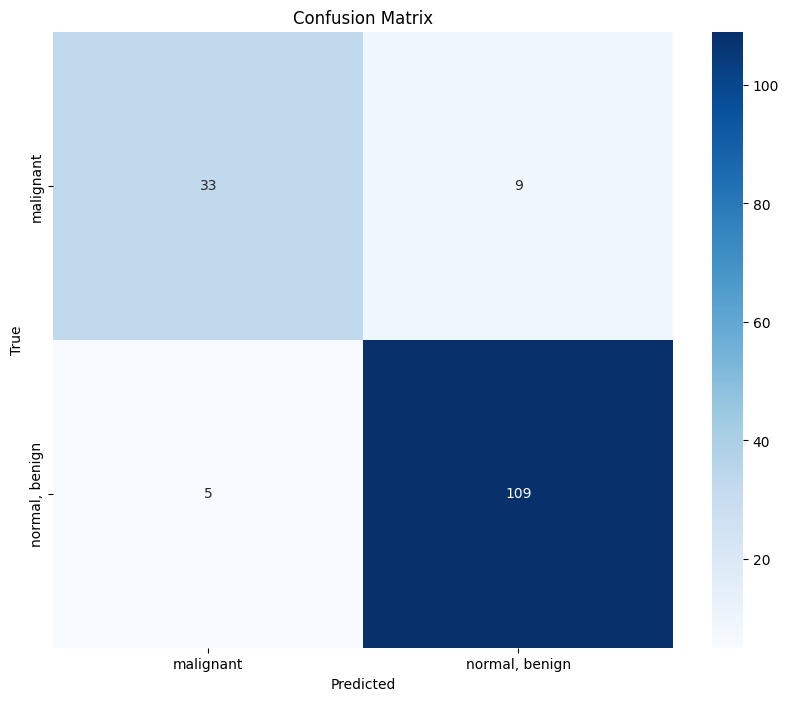

Balanced Accuracy: 0.871
Sensitivity: 0.956
Specificity: 0.8709
Ensemble AUC: 0.840, Ensemble Accuracy: 0.800


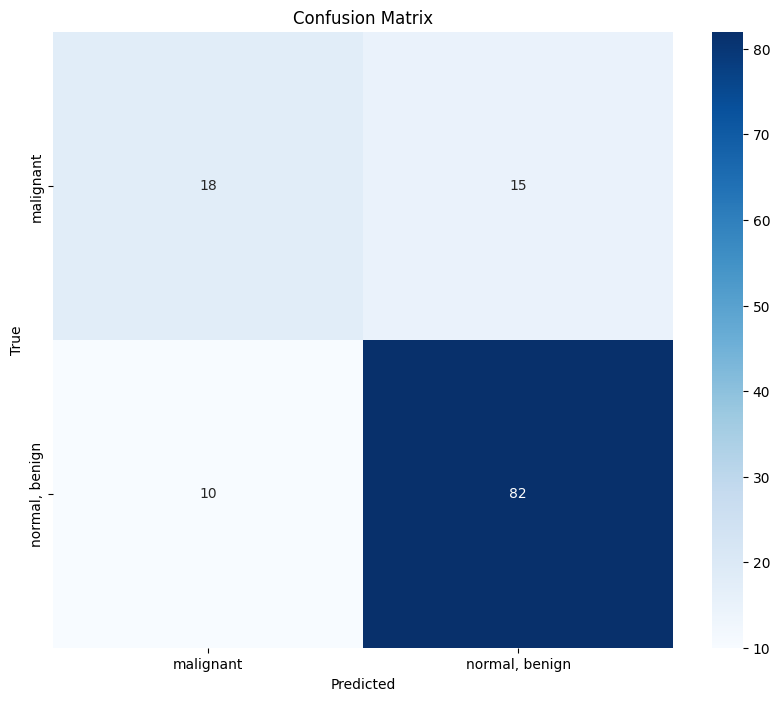

Balanced Accuracy: 0.718
Sensitivity: 0.891
Specificity: 0.7184


In [15]:
y_true, y_scores, digits, indiv_scores = test_eval(test_loader, device=device, models=models, data_flag=flag)
y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

if task_type == 'binary-class':
    y_prob = y_scores
    y_prob_calibration = y_scores_calibration
else:
    y_prob = apply_softmax(y_scores)
    y_prob_calibration = apply_softmax(y_scores_calibration)

if task_type == 'binary-class':
    correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
    incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

    correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
    incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
else:
    correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
    incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

    correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
    incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

In [16]:
#uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap', 'KNNall']
uq_methods = ['GPS']

In [17]:
def call_UQ_methods(
    methods,
    models=None,
    y_prob=None,
    digits=None,
    y_true=None,
    digits_calib=None,
    y_true_calibration=None,
    indiv_scores=None,
    task_type=None,
    correct_predictions=None,
    incorrect_predictions=None,
    test_loader=None,
    device=None,
    optim_metric=None,
    train_loaders=None,
    test_loader_tta=None,
    num_classes=None,
    latent_spaces=None,
    shap_values_folds=None,
    labels_fold=None,
    correct_predictions_calibration=None,
    incorrect_predictions_calibration=None,
    image_normalization=False,
    aug_folder=None,
    gps_augment=None,
    max_iteration=10,
    swarmplot=True
):
    metrics = []
    methods = methods or []
    for method in methods:
        if method == 'MSR':
            if y_prob is not None and y_true is not None and task_type is not None:
                metric = computeMSR(y_prob, y_true, task_type, calibration_needed=False, display_calibration_curve=True)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, '|y_pred-gold_standard|', 'DHL', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'MSR_temp_scale':
            if digits is not None and y_true is not None and task_type is not None and digits_calib is not None and y_true_calibration is not None:
                metric = computeMSR(digits, y_true, task_type, calibration_needed=True, display_calibration_curve=True, method_calibration='temperature', y_scores_calibration=digits_calib, y_true_calibration=y_true_calibration)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, '|y_pred-gold_standard|', 'DHL after temperature scaling', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'Ensembling':
            if indiv_scores is not None:
                metric = compute_ensembling(indiv_scores)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'Ensembling Results', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'TTA':
            if models is not None and test_loader_tta is not None and device is not None:
                metric = computeTTA('randaugment', models, test_loader_tta, device, num_classes=num_classes, image_normalization=image_normalization)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'GPS':
            if models is not None and test_loader_tta is not None and device is not None:
                metric = computeTTA('GPS', models, test_loader_tta, device, num_classes=num_classes, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=image_normalization, aug_folder=aug_folder, max_iterations=max_iteration, gps_augment=gps_augment)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'GPS', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'KNNshap':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None and num_classes is not None and latent_spaces is not None and shap_values_folds is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, num_classes, latent_spaces, shap_values_folds, labels_folds=labels_fold, shap=True)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances after features selection', 'KNNshap', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
        elif method == 'KNNall':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, shap=False)
                display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances', 'KNNall', optim_metric=optim_metric, swarmplot=swarmplot)
                metrics.append((method, metric))
    return metrics

Loading predictions...
Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...


Evaluating policy 1/10...
Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...
Evaluating policy 1/10...



Evaluating policy 1/10...Evaluating policy 1/10...

Evaluating policy 1/10...

Evaluating policy 1/10...
Evaluating policy 1/10...
Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...
Evaluating policy 1/10...



Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...Evaluating policy 1/10...
Evaluating policy 1/10...

Evaluating policy 1/10...
Evaluating policy 1/10...Evaluating policy 1/10...
Evaluating policy 1/10...


Evaluating policy 1/10...

Selected Policy 234: roc_auc=0.8040
Evaluating policy 2/10...
Selected Policy 142: roc_auc=0.7752
Evaluating policy 2/10...
Selected Policy 224: roc_auc=0.7884Selected Policy 142: roc_auc=0.7752

E

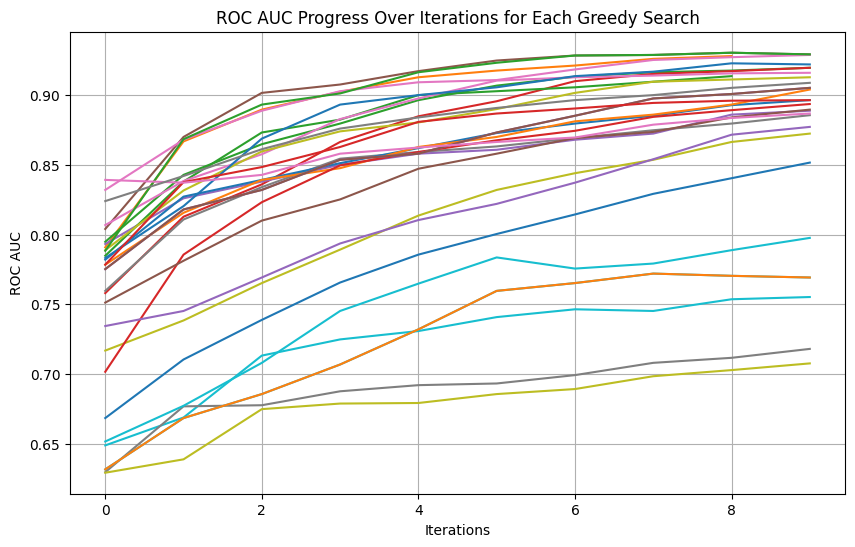

Manually set transform. Current transform: 
[(11,np.float64(25.54478799117382)),(12,np.float64(17.156283912836116))]
Manually set transform. Current transform: 
[(0,np.float64(-25.947314914478305)),(3,np.float64(-12.385719940177893))]
Manually set transform. Current transform: 
[(7,np.float64(-11.635256867730732)),(10,np.float64(-10.613181045958648))]
Manually set transform. Current transform: 
[(8,np.float64(6.405222141223973)),(14,np.float64(19.940459613391937))]
Manually set transform. Current transform: 
[(14,np.float64(13.467673071410204)),(13,np.float64(12.506176066996844))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:549: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


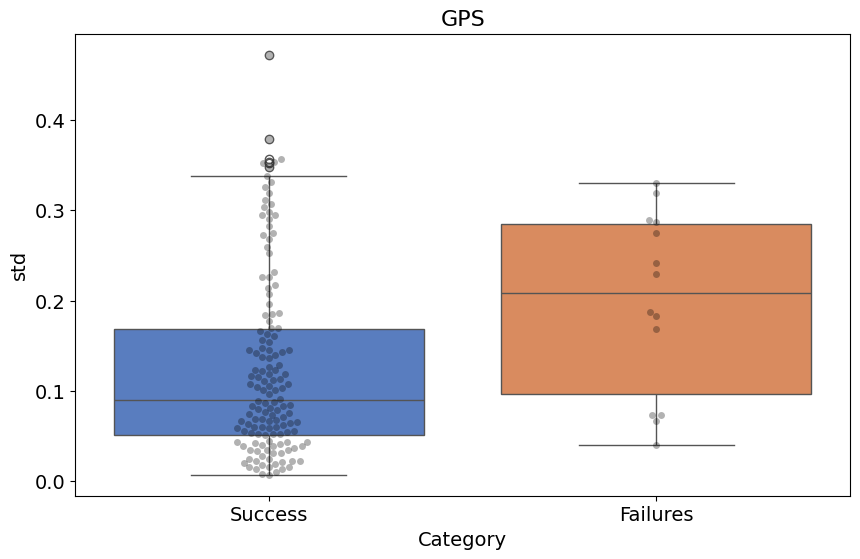

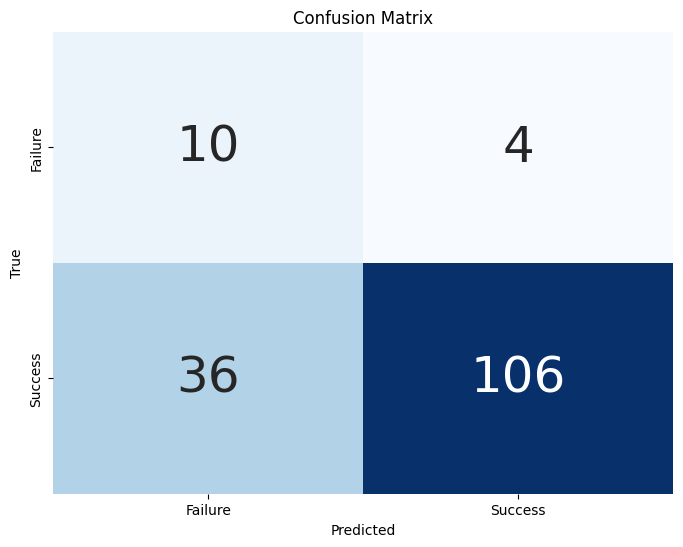

Optimal Threshold: 0.1663892685251126
Balanced Accuracy: 0.7303822937625755
Specificity: 0.7142857142857143
Sensitivity: 0.7464788732394366
0.7057344064386318


In [18]:
uq_metrics = call_UQ_methods(uq_methods, models, test_loader_tta=test_loader_tta, device=device, optim_metric='balanced_accuracy', num_classes=2, correct_predictions=correct_predictions, incorrect_predictions=incorrect_predictions, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=True, aug_folder='gps_augment_breastmnist', swarmplot=True)

In [ ]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [ ]:
#Load the SHAP results from the pickle file
with open('shap_results_calibration.pkl', 'rb') as file:
    shap_results_calibration = pkl.load(file)

In [ ]:
#Load the SHAP results from the pickle file
with open('shap_results.pkl', 'rb') as file:
    shap_results_test = pkl.load(file)

In [ ]:
gps_augment_breastmnist = [2, 45, ['[(7,np.float64(-2.455050670448834)),(14,np.float64(32.01735506796099))]',
                           '[(12,np.float64(16.629404790470353)),(8,np.float64(24.320059225112146))]',
                           '[(11,np.float64(-15.224193700617011)),(14,np.float64(15.956630913145702))]',
                           '[(14,np.float64(13.467673071410204)),(13,np.float64(12.506176066996844))]',
                           '[(12,np.float64(0.051794477305371345)),(5,np.float64(7.642254863572774))]',
                           '[(8,np.float64(6.405222141223973)),(14,np.float64(19.940459613391937))]',
                           '[(7,np.float64(-11.635256867730732)),(10,np.float64(-10.613181045958648))]',
                           '[(6,np.float64(-37.42347709396593)),(13,np.float64(-14.594794915129835))]',
                           '[(5,np.float64(-2.49424487555126)),(8,np.float64(37.257074464895695))]',
                           '[(0,np.float64(42.088808566659196)),(14,np.float64(31.233953205423106))]']]

gps_augment_organamnist = [2, 45, ['[(9, np.float64(18.993544968225756)), (12, np.float64(-1.372124799393923))]',
 '[(9, np.float64(13.796092578543764)), (13, np.float64(9.650253122391298))]',
 '[(9, np.float64(26.753347976507428)), (4, np.float64(-2.269870568517014))]',
 '[(10, np.float64(1.7976877272614402)), (14, np.float64(-2.253227258808664))]',
 '[(11, np.float64(-7.330877383517148)), (13, np.float64(17.226544341423256))]']]

gps_augment_organamnist_calibration = [2, 45, ['[(13, np.float64(9.826685866454547)), (11, np.float64(-1.9805003878025786))]',
 '[(9, np.float64(1.804627907095039)), (12, np.float64(-1.3265139396701287))]',
 '[(9, np.float64(-21.201456998141612)), (0, np.float64(28.024478487844902))]',
 '[(10, np.float64(-6.385809050023269)), (10, np.float64(12.903347343792575))]',
 '[(11, np.float64(-8.335989058024602)), (13, np.float64(-3.0399266781252194))]']]

gps_augment_breastmnist_calibration = [2, 45, ['[(7,np.float64(-10.426594497338968)),(10,np.float64(-34.636498957831094))]',
                                               '[(4,np.float64(-19.94001218581592)),(11,np.float64(32.93686731075451))]',
                                               '[(4,np.float64(30.45475371483745)),(10,np.float64(6.140905291383014))]',
                                               '[(3,np.float64(-42.467409224329025)),(9,np.float64(-32.560998409604096))]',
                                               '[(3,np.float64(-23.9867688031166)),(12,np.float64(14.485217838839816))]']]

In [ ]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
labels_fold = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=calibration_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=125
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
models = [model.to(device) for model in models]
latent_spaces_calibration = []
shap_values_folds_calibration = []
success_folds_calibration = []
labels_fold_calibration = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=156
    )
    latent_spaces_calibration.append(shap_features)
    shap_values_folds_calibration.append(shap_values)
    success_folds_calibration.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold_calibration.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
for fold in range(5):
    print(fold)
    latent_space_training, labels_train, flags_train, _ = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        importance=False
    )
    
    latent_space_test, labels_test, flags_test, _ = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        importance=False
    )
    
    train_latent_space = pd.DataFrame(latent_space_training)
    test_latent_space = pd.DataFrame(latent_space_test)
        
    # Print the initial number of dimensions
    print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
        
    scaler = StandardScaler()
    train_latent_space_standardized = scaler.fit_transform(train_latent_space)
    # Apply UMAP for dimensionality reduction to 2D
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    train_latent_space_umap = umap_reducer.fit_transform(train_latent_space_standardized)
    test_latent_space_umap = umap_reducer.transform(scaler.transform(test_latent_space))

    # Print the reduced dimensions
    print(f"Reduced dimensions (train): {train_latent_space_umap.shape}")
    print(f"Reduced dimensions (test): {test_latent_space_umap.shape}")
    
    uq.visualize_umap_with_labels(train_latent_space_umap, test_latent_space_umap, flags_test, labels_train, fold)

In [ ]:
uq_metrics_calibration = call_UQ_methods(uq_methods, models, y_prob_calibration, y_scores_calibration, y_true_calibration, y_scores, y_true, indiv_scores_calib, task_type, correct_predictions_calibration, incorrect_predictions_calibration, calibration_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=calibration_loader, num_classes=11, latent_spaces=shap_results_test['latent_spaces'], shap_values_folds=shap_results_test['shap_values_folds'], labels_fold=None, correct_predictions_calibration=correct_predictions, incorrect_predictions_calibration=incorrect_predictions, image_normalization=False, aug_folder='savedpolicies_testset', swarmplot=False, gps_augment=gps_augment_organamnist_calibration)

In [ ]:
mean_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
	), 'mean'
)
min_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
	), 'min'
)
max_values = uq.standardize_and_ensemble(
    np.column_stack(
        [uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
	), 'max'
)

In [ ]:
display_UQ_results(mean_values, correct_predictions, incorrect_predictions, 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=False)

In [ ]:
display_UQ_results(max_values, correct_predictions, incorrect_predictions, 'Max(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='balanced_accuracy', swarmplot=False)

In [ ]:
display_UQ_results(min_values, correct_predictions, incorrect_predictions, 'Min(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=False)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the calibration data
X_calibration = np.column_stack([uq_metrics_calibration[i][1] for i in range(len(uq_metrics_calibration)) if uq_metrics_calibration[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']])
y_calibration = np.array([1 if i in correct_predictions_calibration else 0 for i in range(len(uq_metrics_calibration[0][1]))])

class_weights = compute_class_weight('balanced', classes=np.unique(y_calibration), y=y_calibration)
class_weight_dict = {0: class_weights[1], 1: class_weights[0]}

# Prepare the test data
X_test = np.column_stack([uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']])

# Create a perceptron model with a standard scaler
perceptron = make_pipeline(StandardScaler(), Perceptron(class_weight=class_weight_dict))

# Train the perceptron on the calibration data
perceptron.fit(X_calibration, y_calibration)

# Get the scores for all test data
test_scores = perceptron.decision_function(X_test)

# Print the test scores
print(test_scores)

In [ ]:
display_UQ_results(-test_scores, correct_predictions, incorrect_predictions, 'Perceptron trained on calibration data', 'UQ methods combination', optim_metric='specificity', swarmplot=False)

In [ ]:
fpr_percep, tpr_percep, auc_percep = uq.roc_curve_UQ_method_computation([-test_scores[k] for k in correct_predictions], [-test_scores[j] for j in incorrect_predictions])
fpr_mean, tpr_mean, auc_mean = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
fpr_max, tpr_max, auc_max = uq.roc_curve_UQ_method_computation([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions])
fpr_min, tpr_min, auc_min = uq.roc_curve_UQ_method_computation([min_values[k] for k in correct_predictions], [min_values[j] for j in incorrect_predictions])

In [ ]:
uq.roc_curve_UQ_methods_plot(['Perceptron', 'Mean', 'Max', 'Min'], [fpr_percep, fpr_mean, fpr_max, fpr_min], [tpr_percep, tpr_mean, tpr_max, tpr_min], [auc_percep, auc_mean, auc_max, auc_min])

In [ ]:
fprs = []
tprs = []
aucs = []
for method in uq_metrics:
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([method[1][k] for k in correct_predictions], [method[1][j] for j in incorrect_predictions])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)

In [ ]:
uq.roc_curve_UQ_methods_plot(uq_methods, fprs, tprs, aucs)